---

### 🔍 **What is Micro Partition Depth?**

#### 💡 Basic idea:

Think of **Micro Partitions (MPs)** as **blocks of data** (typically 16 MB compressed) that Snowflake automatically creates when you load data into a table.

Now imagine you're querying a column, and you want Snowflake to find only the MPs that contain relevant data. **Micro Partition Depth** is how **deep** Snowflake must **go into the physical MP metadata tree** to find your relevant data.

---

### 🧠 **Let’s Use an Analogy (You love real-world mappings)**

#### 🏢 Imagine a Building (Your Table)

* Each **floor** = a **Micro Partition**
* Each floor contains **boxes** = rows with column values
* You’re searching for something: “Give me all records where `country = 'USA'`.”

#### ❓Now, what happens?

* If **each floor is organized by country**, and the **USA boxes are all close together** — you can just **go directly to the USA floor and open a few boxes**.
* But if data is **scattered across many floors**, and USA appears **on floor 1, 5, 10, 25**, etc., you’ll **have to go deeper** — scanning **more floors (MPs)**.

That’s **depth**. More **depth = more effort to locate data** = slower query performance.

---

### ⚙️ **What Exactly is Micro Partition Depth in Snowflake Terms?**

In Snowflake:

* Snowflake keeps metadata for each MP: min/max of each column, number of distinct values, null count, etc.
* When a **cluster key** is defined, Snowflake **reorganizes MPs** to physically group similar data — like all USA data near each other.
* The **Micro Partition Depth** measures **how many levels of filtering/searching** Snowflake has to do in its MP metadata tree to locate your target data.

---

### 🎯 **Purpose of Micro Partition Depth**

* To measure **how efficiently data is physically organized**.
* Lower depth = data is **well clustered**, **fewer MPs scanned**, **faster queries**.
* Helps in monitoring and evaluating the **effectiveness of your clustering strategy**.

---

### 🌟 **Benefits of Managing Micro Partition Depth**

| Benefit                    | Why it matters                                  |
| -------------------------- | ----------------------------------------------- |
| ✅ Faster Query Performance | Less MPs to scan → faster execution             |
| ✅ Lower Compute Costs      | Less CPU → fewer credits consumed               |
| ✅ Easier Pruning           | Metadata-based pruning becomes effective        |
| ✅ Better Maintenance       | Helps tuning and planning clustering strategies |

---

### 🧱 **What Problem Does It Solve?**

When data is **inserted randomly** (like with ongoing streaming or batch DML), the MPs get **fragmented**. For example:

```plaintext
MP1: USA, India, Brazil  
MP2: USA, China, UK  
MP3: India, UK, Brazil  
MP4: USA, Brazil, China
```

Even though you query for `country = 'USA'`, Snowflake **must scan all** MPs. That's inefficient.

👉 By monitoring and controlling **micro partition depth**, we can **physically reorganize** data to reduce this scanning — and **optimize pruning**.

---

### 📊 **Example Scenario**

#### Table: `sales_data`

Columns: `country`, `city`, `sale_date`, `amount`

You frequently run:

```sql
SELECT * FROM sales_data WHERE country = 'USA' AND sale_date >= '2023-01-01';
```

But your data is not clustered → MP depth is high (say 20).

Now you **define a cluster key**:

```sql
CLUSTER BY (country, sale_date)
```

After a few recluster operations, Snowflake reorganizes data:

```plaintext
MP1: USA, 2023-01-01 to 2023-01-05  
MP2: USA, 2023-01-06 to 2023-01-10  
MP3: India, 2023-01-01 to 2023-01-10
...
```

Now, to answer your query, Snowflake only needs to scan **MP1 and MP2** — pruning is **fast**, depth is **low (e.g. 2)**.

---

### 🧬 **Types of Micro Partition Depth**

#### These are *not official types*, but conceptual levels to help you **understand in depth**:

| Type                   | Description                                          | When Happens                                               |
| ---------------------- | ---------------------------------------------------- | ---------------------------------------------------------- |
| 🔹 Shallow Depth (0-3) | Data is **well clustered**, pruning is **efficient** | With **good clustering keys** and **no recent random DML** |
| 🔸 Medium Depth (4-15) | Some fragmentation, pruning is **okay-ish**          | After some DML, no clustering                              |
| 🔺 Deep Depth (16+)    | Data is **highly fragmented**, pruning is **poor**   | No clustering + heavy insert/update/delete                 |

---

### 🚨 **Precautions Before Applying Cluster Keys**

1. **Clustering is not free** – Snowflake **automatically maintains clustering**, which **costs compute**.
2. **Best for large tables** – At least **multi-GB, preferably TB scale**.
3. Only **beneficial** when your **queries filter by the clustered columns**.
4. Too frequent DMLs → constant reclustering → cost may outweigh benefit.
5. Snowflake might **auto-cluster** based on usage if you don't manually define it — but **manual clustering gives control**.

---

### 🧭 **Best Practices**

| Do                                                                    | Don’t                                                        |
| --------------------------------------------------------------------- | ------------------------------------------------------------ |
| Use clustering when you often query by specific filters               | Don’t use clustering on small or infrequently queried tables |
| Monitor micro partition depth using `SYSTEM$CLUSTERING_INFORMATION()` | Don’t assume clustering improves all queries                 |
| Cluster on **columns with high cardinality and frequent filtering**   | Avoid clustering on columns with very few distinct values    |
| Reevaluate clustering keys if DML patterns change                     | Don’t set it and forget it                                   |

---

### 🛠️ **Snowflake System Function to Check Depth**

You can check how well your clustering is working (aka depth):

```sql
SELECT SYSTEM$CLUSTERING_INFORMATION('your_table_name');
```

This returns:

* Average Depth
* Total micro partitions
* Clustered columns
* Number of overlapping MPs

---

### ✅ Summary Table

| Term            | Meaning                                                          |
| --------------- | ---------------------------------------------------------------- |
| Micro Partition | 16MB compressed chunk of table data                              |
| MP Depth        | Number of MPs scanned (metadata tree depth) for filtered queries |
| Goal            | Keep MP depth **low** using **smart clustering**                 |
| Ideal Tables    | TB-scale tables queried with WHERE conditions on a few columns   |
| Danger          | Over-clustering can waste compute credits                        |
| Check           | Use `SYSTEM$CLUSTERING_INFORMATION()`                            |

---


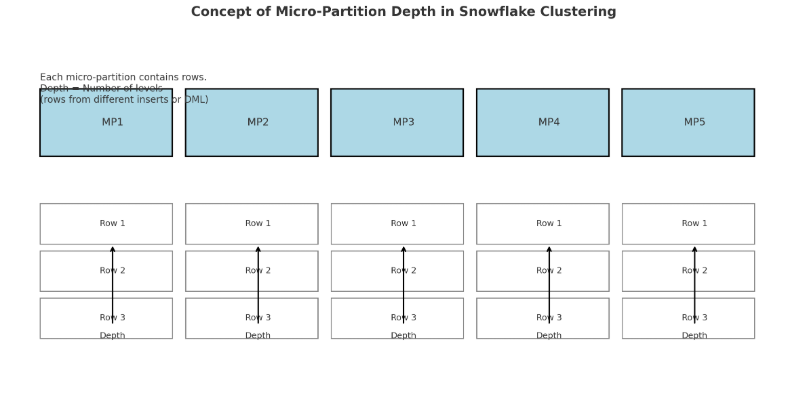

### Key Concepts:


Micro-Partition (MP): Each horizontal block (MP1–MP5) represents a micro-partition.

Depth: The vertical stack of rows inside each MP shows how many layers of data exist due to multiple INSERTs, UPDATEs, or DELETEs.

More depth = more fragmentation, which may lead to slower pruning and reduced performance.



---

## ✅ What is **Micro-Partition Depth Overlapping**?

### 📌 Definition:

**MCP depth overlapping** refers to the situation when **multiple micro-partitions** cover **overlapping ranges of values** for the **same clustering key** — typically because of **DML operations** (INSERT/UPDATE/DELETE) over time.

---

### 📦 Visual Analogy:

Imagine you’re organizing books on a shelf by **genre (clustering key)**.

| 📚 Shelf (Micro-Partition) | Covered Genre Range (e.g., A-Z) |
| -------------------------- | ------------------------------- |
| MP1                        | A–C                             |
| MP2                        | D–F                             |
| MP3                        | G–I                             |

Now, due to some updates and new inserts:

* MP4 also holds A–C (overlapping with MP1)
* MP5 holds B–E (overlapping with MP1 and MP2)

➡️ **Now genre A–F exists in *multiple* micro-partitions.**
This is **depth overlap** — multiple MPs cover **the same range**.

---

### 📌 Why It’s Bad:

* **Query pruning becomes harder** — Snowflake must scan *all* MPs that touch the same range.
* **Storage cost increases** — more micro-partitions for same data.
* **Performance suffers** — less benefit from clustering.

---

## 🔄 What Happens During DML Operations?

Every time you do a **DML operation**, here’s what happens under the hood:

### 1. **INSERT**:

* New data is written into **new micro-partitions**.
* These new MPs might **overlap** with existing MPs if clustering is not aligned.
* ⬆️ **Depth increases**, more overlap.

### 2. **UPDATE**:

* Snowflake is **append-only** → it doesn't edit in place.
* It creates new micro-partitions with updated data.
* Marks old rows as logically deleted (but still stored for time travel).
* ➕ Adds **new depth layers**, causes more **overlap**.

### 3. **DELETE**:

* Old data isn’t removed immediately.
* Marked as deleted but remains for **time travel/failsafe**.
* Query pruning still sees the micro-partition → **still contributes to depth**.

---

## 📉 Micro-Partition Depth Change Over Time

Here's a **timeline-style explanation**:

| Time | Action                       | Micro-Partition Effect                           | Depth        |
| ---- | ---------------------------- | ------------------------------------------------ | ------------ |
| T1   | Bulk INSERT sorted by `date` | MP1 (2023), MP2 (2024)                           | 1            |
| T2   | Small INSERT of 2023 data    | MP3 (2023 again)                                 | 2 (for 2023) |
| T3   | UPDATE some 2023 rows        | MP4 (new rows for 2023), MP1 rows marked deleted | 3            |
| T4   | DELETE some 2023 rows        | Mark rows deleted, MP still needed               | 3+           |

➡️ **Result**: You now have **3+ micro-partitions** covering 2023. Depth = 3+

---

## 🔧 Snowflake to the Rescue: **Reclustering**

Snowflake periodically **re-clusters** data **automatically** (or you can trigger it manually if you pay for it).
This reduces:

* Overlapping depth
* Micro-partition fragmentation
* Improves pruning

🧠 Think of this as **defragmentation** like we did in old-school Windows computers.

---

## 📘 Real Scenario

**Clustering key**: `event_date`
**Table**: `user_logs`

* Initial insert: Jan–Dec 2023 — 12 MPs, nicely sorted.
* Small daily insert for Jan again → creates new MP overlapping Jan.
* Update some Jan rows — creates even more MPs covering Jan.
* Now Jan data exists in **MP1, MP13, MP14, MP15** — depth = 4.

Without reclustering:

* Query for Jan = Scans 4 MPs.
* With good clustering = Scans 1 MP.

---


## What is the difference between total partition count vs total constant partition count?

## 🔹 What is **Micro-Partition (MP) Depth Overlapping**?

### ✅ Definition:

**MP Depth Overlapping** refers to a situation where **multiple versions of rows** for the **same clustering key range** exist across **different micro-partitions** **because of DML operations** (like `INSERT`, `UPDATE`, or `DELETE`).

---

### 📦 Example:

Let’s say your table is clustered by `DATE`.

| Operation       | Micro-Partition | Affected Date               |
| --------------- | --------------- | --------------------------- |
| Original Insert | MP1             | 2024-01-01 to 2024-01-10    |
| Update          | MP2             | 2024-01-05 (new version)    |
| Delete          | MP3             | 2024-01-08 (deleted marker) |

Now:

* **MP1** still contains the **original rows** from Jan 1 to Jan 10.
* **MP2** contains an **updated version** of Jan 5.
* **MP3** contains a **deleted version** of Jan 8.

🧠 That means **the same date (e.g. Jan 5 or Jan 8)** exists in **multiple partitions (MP1 + MP2/MP3)** → **this is depth overlap**.

---

### 📉 Why It's a Problem:

* It **increases depth** for the same key range.
* Snowflake’s pruning engine has to scan **more partitions** to find the latest or correct version.
* **Query performance degrades** (especially range filters on clustering key).

---

## 🔄 What Happens During DML Operations?

| DML Operation | What It Does to Micro-Partitons                                                                         |
| ------------- | ------------------------------------------------------------------------------------------------------- |
| **INSERT**    | Adds new micro-partition(s). May or may not overlap existing ones.                                      |
| **UPDATE**    | Old row is **logically deleted**, new row is **inserted** → **creates a new MP**, increasing **depth**. |
| **DELETE**    | Marks the row as deleted in a **new MP**. Again, **adds depth**.                                        |

So each DML operation causes **new MP layers** to be added **without cleaning up the old ones immediately**.

---

### 🧱 Imagine it like building **Jenga blocks**:

* Every DML adds more **blocks on top of the same key range**, making the stack higher (i.e., deeper).
* At some point, it's **inefficient** and **slow** to find a block — that's why **reclustering** exists.

---

## 🔹 Total Partition Count vs Total Constant Partition Count

### ✅ Definitions:

| Metric                             | Description                                                                                                      |
| ---------------------------------- | ---------------------------------------------------------------------------------------------------------------- |
| **Total Partition Count**          | The total number of **micro-partitions** involved in the table.                                                  |
| **Total Constant Partition Count** | The number of **partitions** where the **clustering key value(s) don't vary** — they’re constant inside that MP. |

---

### 📦 Example:

Let's say you're clustering by `region` and you have:

* **MP1** = All rows for `region = 'US'` → Constant
* **MP2** = Rows for `region = 'US', 'EU', 'ASIA'` → Not constant

| Metric                         | Value        |
| ------------------------------ | ------------ |
| Total Partition Count          | 2            |
| Total Constant Partition Count | 1 (only MP1) |

---

### 📊 Why It Matters:

* Higher **constant partition count** = **better pruning** potential.
* If most partitions are **mixed** (non-constant), your clustering is **not very effective**.
* Helps Snowflake determine if **reclustering** or changing **cluster key strategy** is needed.

---



---

## 💡 2. **Types of Clustering You Can Do**

You **define cluster keys** based on query filtering needs.

### 🔹 a. Single Cluster Key

```sql
CLUSTER BY (country)
```

Good if queries often filter on:

```sql
WHERE country = 'US'
```

---

### 🔸 b. Multi Cluster Key

```sql
CLUSTER BY (country, city)
```

More specific — useful when filtering like:

```sql
WHERE country = 'US' AND city = 'New York'
```

Snowflake clusters left to right, so:

* **country is major key**
* **city is minor key**

---

### 🔹 c. Multi Cluster (with transformations)

```sql
CLUSTER BY (country, SUBSTRING(city, 1, 4))
```

Useful for patterns or prefixes:

* Cluster based on part of a field, e.g. ZIP code, city code.

---

### 🔸 d. Function-based clustering

```sql
CLUSTER BY (TO_DATE(created_at))
```

For **timestamp fields**, cluster by only the **date** part, reducing granularity and improving pruning.

---

## ⚠️ 3. Pre-cautions Before Applying Cluster Keys

Clustering isn't **free** — it **costs credits** (via background reclustering).

So, follow these **best practices**:

### ✅ a. Not for all tables

* Don’t cluster **small tables** — it adds cost but no real performance gain.

---

### ✅ b. Table must be **large enough**

* Ideally **multi-terabyte scale**.
* You need enough micro-partitions to benefit from pruning.

---

### ✅ c. Keys should offer **good filtering**

* Use columns that:

  * Are often used in `WHERE` clauses.
  * Have **good cardinality** (not just one or two values).
  * Help reduce micro-partition depth.

---

### ✅ d. Ideal for **frequently queried, large, and updated tables**

* Especially if you do **regular DML** (INSERTs, DELETEs).
* Snowflake can **recluster** automatically in the background.

---

### ❌ Avoid Clustering If:

| Table Size | Query Patterns     | Clustering Good Idea? |
| ---------- | ------------------ | --------------------- |
| Small      | Simple scans       | ❌ No                  |
| Medium     | Rarely queried     | ❌ No                  |
| Large      | No filtering       | ❌ No                  |
| Large      | Time-based filters | ✅ Yes                 |
| Large      | Frequent DML       | ✅ Yes                 |

---



---

### ❓ When does Snowflake delete unnecessary micro-partitions?

**Short Answer:**
Snowflake **never directly deletes** individual micro-partitions on its own — instead, it uses **automatic background processes** like **Automatic Clustering** and **Table Optimization Services** to **consolidate**, **merge**, and **rewrite** micro-partitions to reduce depth and improve performance.

---

### 🔄 What happens behind the scenes:

#### 1. **DML operations (INSERT, UPDATE, DELETE)** create new micro-partitions:

* Every DML modifies data by **writing new micro-partitions**, not updating existing ones.
* Old versions become **inactive** but are **retained temporarily** for:

  * **Time Travel** (default 1 day, configurable up to 90 days)
  * **Fail-safe** (7-day backup by Snowflake)

#### 2. **Micro-partitions remain in storage during:**

* **Time Travel retention period**
* **Fail-safe period** (you can't access them; Snowflake can restore them)

---

### 🧹 When and how they are cleaned up:

| Phase                          | Action                                                                                   |
| ------------------------------ | ---------------------------------------------------------------------------------------- |
| ✅ **Time Travel ends**         | Micro-partitions marked for **purge**                                                    |
| ✅ **Fail-safe ends**           | Micro-partitions are **permanently deleted by Snowflake** (auto)                         |
| 🔁 **Clustering/Optimization** | Snowflake may **rewrite and merge** small/fragmented micro-partitions to improve pruning |

---

### 🧠 Example to understand:

Let’s say your table has 10 billion rows, and you:

* Run daily `DELETE` for old data
* And `INSERT` new data

This will:

* Create new micro-partitions each day
* Mark deleted partitions as “inactive”
* Keep them available for Time Travel

After Time Travel + Fail-safe:

* Snowflake cleans them up automatically
* Optimization services might compact many small partitions into fewer, deeper ones

---